# Download & Import Library

In [ ]:
!pip install opencv-python matplotlib

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

print("the version of tensorflow that use in this session is " + tf.__version__)

the version of tensorflow that use in this session is 2.14.0


In [ ]:
pip install split-folders

In [ ]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import splitfolders
import os, os.path
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import numpy as np
from google.colab import files
import keras.utils as image

2.14.0


# Load File

In [ ]:
# path joining version for other paths - Banyaknya data yang dimiliki
DIR = '/content/drive/MyDrive/Colab Notebooks/Stuntrack/Data Train'
print ("Training data", sum(len(files) for _, _, files in os.walk(DIR)))
DIR = '/content/drive/MyDrive/Colab Notebooks/Stuntrack/Data Validation'
print ("Testing data", sum(len(files) for _, _, files in os.walk(DIR)))

Training data 35
Testing data 9


In [ ]:
#Memasukkan semua data ke variabel - Train & Validation DIR Folder Data
base_dir = '/content/drive/MyDrive/Colab Notebooks/Stuntrack/'
train_dir = os.path.join(base_dir, 'Data Train')
validation_dir = os.path.join(base_dir, 'Data Validation')

In [ ]:
#Direktori data training
train_one_dir = os.path.join(train_dir, 'TIDAK STUNTING')
train_two_dir = os.path.join(train_dir, 'STUNTING')

#Direktori data Validation
validation_one_dir = os.path.join(validation_dir, 'TIDAK STUNTING')
validation_two_dir = os.path.join(validation_dir, 'STUNTING')

# Image Preprocessing

In [ ]:
# Check Image Size

folder_images1 = "/content/drive/MyDrive/Colab Notebooks/Stuntrack/Data Train/TIDAK STUNTING"
folder_images2 = "/content/drive/MyDrive/Colab Notebooks/Stuntrack/Data Train/STUNTING"

size_images = dict()

for dirpath, _, filenames in os.walk(folder_images2):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}
print(size_images)

{'TB14.jpg': {'width': 2250, 'heigth': 4000}, 'TB15.jpg': {'width': 2250, 'heigth': 4000}, 'TB11.jpg': {'width': 2592, 'heigth': 4608}, 'TB13.jpg': {'width': 4608, 'heigth': 2592}, 'TB8.jpg': {'width': 2250, 'heigth': 4000}, 'TB9.jpg': {'width': 2250, 'heigth': 4000}, 'TB12.jpg': {'width': 2592, 'heigth': 4608}, 'TB10.jpg': {'width': 2250, 'heigth': 4000}, 'TB7.jpg': {'width': 2592, 'heigth': 4608}, 'TB6.jpg': {'width': 2250, 'heigth': 4000}, 'TB5.jpg': {'width': 2250, 'heigth': 4000}, 'TB4.jpg': {'width': 2250, 'heigth': 4000}, 'TB3.jpg': {'width': 2250, 'heigth': 4000}, 'TB1.jpg': {'width': 2592, 'heigth': 4608}, 'TB2.jpg': {'width': 2250, 'heigth': 4000}}


In [ ]:
# Image augmentation

train_datagenerator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=90, #random rotation antara 0-90 derajat
                    width_shift_range=0.2, #prosentasi width untuk random shift
                    height_shift_range=0.2, #prosentasi height untuk random shift
                    horizontal_flip=True, #horizontal flip untuk posisi tangan horizontal
                    brightness_range=[0.2,1.0], #mainkan brightness kalau ada kekurangan cahaya
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagenerator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=90, #random rotation antara 0-90 derajat
                    width_shift_range=0.2, #prosentasi width untuk random shift
                    height_shift_range=0.2, #prosentasi height untuk random shift
                    horizontal_flip=True, #horizontal flip untuk posisi tangan horizontal
                    brightness_range=[0.3,1.0], #mainkan brightness kalau ada kekurangan cahaya
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
#Persiapan Data Training dan Validasi Generator
train_generator = train_datagenerator.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 256x256 piksel
        batch_size=4,
        # Klasifikasi Multi-Class (>2)
        class_mode='categorical')

validation_generator = test_datagenerator.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 256x256 piksel
        batch_size=4,
        # Klasifikasi Multi-Class (>2)
        class_mode='categorical')
# X, y = next(train_generator)

Found 35 images belonging to 2 classes.
Found 9 images belonging to 2 classes.


# Build Model ANN and Callback Function

In [ ]:
#Penggunaan Callback untuk menghentikan proses training sesuai akurasi yang diinginkan

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')

        if val_accuracy is not None and accuracy is not None:
            if val_accuracy > 0.9 and accuracy > 0.9:
                print("\nSudah >90% nih akurasinya jadi diberhentikan saja!")
                self.model.stop_training = True
            else:
                print("\nBelum mencapai akurasi >90%, lanjutkan training.")
        else:
            print("\nNilai akurasi tidak tersedia. Lanjutkan training.")


callbacks = myCallback()

#Model sederhana Deep Learning 5 Conv dan 2 Fully Connected Layer
model = tf.keras.models.Sequential([ #Menggunakan model Sequential
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3), #melakukan dropout pada 20% dari unit output
  tf.keras.layers.Dense(2, activation='softmax') #3 kelas (???)
])

# Meng-compile model dengan Adam Optimizer dengan loss Categorical_Crossentropy karena multiclass classification
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [ ]:
start_time = time.time() # Hitung waktu eksekusi training
epoh = 200 # Tentukan banyaknya epoch-nya
batch_size = 4

# Hitung steps_per_epoch dan validation_steps
steps_per_epoch = int(np.ceil(35 / batch_size))  # Contoh: 9
validation_steps = int(np.ceil(9 / batch_size))  # Contoh: 3



from tensorflow.keras.callbacks import EarlyStopping

# Tentukan kondisi EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor akurasi pada data validasi
    patience=10,  # Toleransi untuk tidak ada peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik ketika berhenti
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epoh,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[callbacks, early_stopping],
    verbose=2
)

print("--- Waktu training adalah %s detik ---" % (time.time() - start_time))


Epoch 1/200

Belum mencapai akurasi >90%, lanjutkan training.
9/9 - 40s - loss: 0.9382 - accuracy: 0.6000 - val_loss: 0.6855 - val_accuracy: 0.5556 - 40s/epoch - 4s/step
Epoch 2/200

Belum mencapai akurasi >90%, lanjutkan training.
9/9 - 6s - loss: 0.7069 - accuracy: 0.3429 - val_loss: 0.6939 - val_accuracy: 0.2222 - 6s/epoch - 638ms/step
Epoch 3/200

Belum mencapai akurasi >90%, lanjutkan training.
9/9 - 8s - loss: 0.7157 - accuracy: 0.5143 - val_loss: 0.6926 - val_accuracy: 0.5556 - 8s/epoch - 865ms/step
Epoch 4/200

Belum mencapai akurasi >90%, lanjutkan training.
9/9 - 6s - loss: 0.6925 - accuracy: 0.5714 - val_loss: 0.6916 - val_accuracy: 0.5556 - 6s/epoch - 659ms/step
Epoch 5/200

Belum mencapai akurasi >90%, lanjutkan training.
9/9 - 8s - loss: 0.6903 - accuracy: 0.5714 - val_loss: 0.6900 - val_accuracy: 0.5556 - 8s/epoch - 916ms/step
Epoch 6/200

Belum mencapai akurasi >90%, lanjutkan training.
9/9 - 6s - loss: 0.6852 - accuracy: 0.5714 - val_loss: 0.6839 - val_accuracy: 0.5556

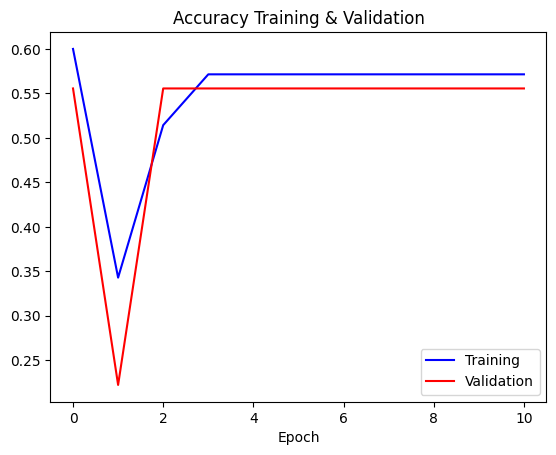

In [ ]:
plt.plot(history.history['accuracy'], label='Training', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation', color='red')
plt.title('Accuracy Training & Validation')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

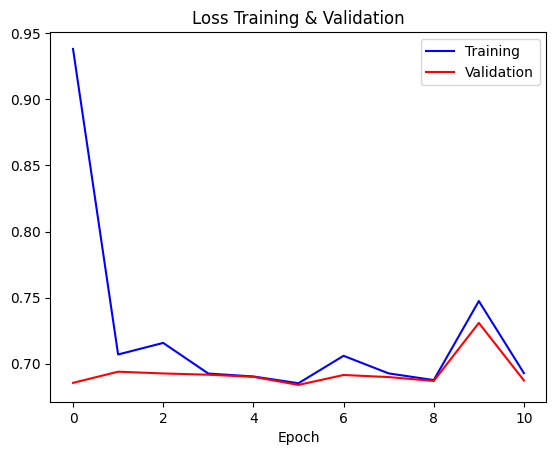

In [ ]:
plt.plot(history.history['loss'], label='Training', color='blue')
plt.plot(history.history['val_loss'], label='Validation', color='red')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# from tensorflow.keras.preprocessing import image

# uploaded = files.upload()

# # Cetak nilai train_generator.class_indices
# print("Class Indices:", train_generator.class_indices)

# for fn in uploaded.keys():
#     # predicting images
#     path = '/content/' + fn
#     img = image.load_img(path, target_size=(150, 150))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)

#     images = np.vstack([x])
#     classes = model.predict(images, batch_size=10)
#     print("Model Predictions:", classes)  # Cetak nilai hasil prediksi dari model
#     plt.axis('Off')
#     plt.imshow(img)
#     plt.show()

#     predicted_class_indices = np.argmax(classes, axis=1)
#     labels = train_generator.class_indices
#     labels = dict((v, k) for k, v in labels.items())
#     predictions = [labels[k] for k in predicted_class_indices]
#     print("Alamat file:", fn)
#     print("Gambar ini terdeteksi oleh sistem sebagai " + str(predictions[0]))


In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Stuntrack/Hasil Model/First Model')
# print("Berhasil")

In [ ]:
# Test
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Stuntrack/Hasil Model/First Model')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 64)       

In [ ]:
train_generator.class_indices

validation_generator.class_indices

{'STUNTING': 0, 'TIDAK STUNTING': 1}

1/1 [==============================] - 0s 154ms/step


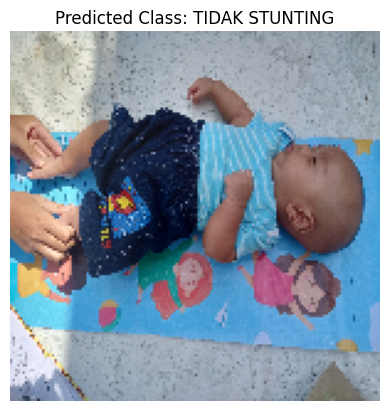

File: TB Stun 2.jpg
Predictions: [[0.01335602 0.98664397]]
Predicted Class: TIDAK STUNTING

1/1 [==============================] - 0s 42ms/step


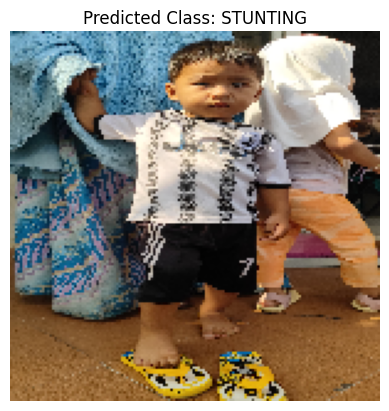

File: TB Stun 1.jpg
Predictions: [[0.8801349  0.11986513]]
Predicted Class: STUNTING

1/1 [==============================] - 0s 30ms/step


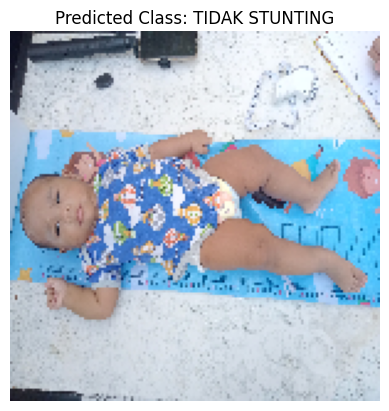

File: TB Stun 3.jpg
Predictions: [[0.00323142 0.9967686 ]]
Predicted Class: TIDAK STUNTING

1/1 [==============================] - 0s 29ms/step


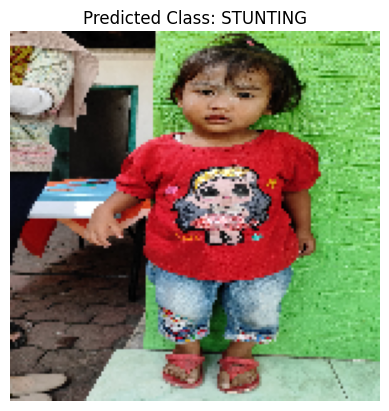

File: TB No Stun 1.jpg
Predictions: [[0.8776349  0.12236517]]
Predicted Class: STUNTING

1/1 [==============================] - 0s 31ms/step


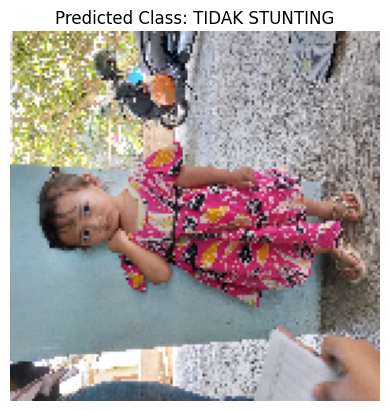

File: TB No Stun 2.jpg
Predictions: [[0.0697447 0.9302553]]
Predicted Class: TIDAK STUNTING

1/1 [==============================] - 0s 28ms/step


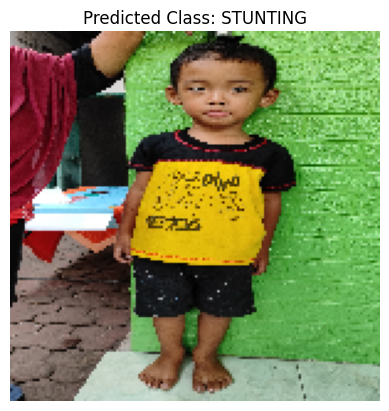

File: TB No Stun 3.jpg
Predictions: [[0.5938776  0.40612242]]
Predicted Class: STUNTING



In [ ]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Gantilah 'path_to_model' dengan path ke model kamu
path_to_model = '/content/drive/MyDrive/Colab Notebooks/Stuntrack/Hasil Model/First Model'
# Load model
loaded_model = load_model(path_to_model)

# Gantilah 'path_to_folder' dengan path ke folder tempat kamu menyimpan foto-foto
path_to_folder = '/content/drive/MyDrive/Colab Notebooks/Stuntrack/Data Test'

# Loop melalui semua file dalam folder
for filename in os.listdir(path_to_folder):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # Gantilah 'path_to_folder' dengan path ke folder tempat kamu menyimpan foto-foto
        img_path = os.path.join(path_to_folder, filename)

        # Lakukan prediksi menggunakan model.predict
        img = image.load_img(img_path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x /= 255.0  # Normalisasi jika diperlukan
        predictions = loaded_model.predict(x)
        class_labels = ["STUNTING", "TIDAK STUNTING"]
        # Tampilkan foto
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted Class: {class_labels[np.argmax(predictions)]}")
        plt.show()

        print(f"File: {filename}")
        print("Predictions:", predictions)
        # Gantilah 'class_labels' dengan label kelas yang sesuai dengan model kamu
        predicted_class = class_labels[np.argmax(predictions)]
        print(f"Predicted Class: {predicted_class}")
        print()